In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df = pd.read_csv("../DataSets/Egypt_Houses_Price.csv")
df['Level'] = df['Level'].replace({'Unknown': 0, 'Ground': 0, '10+': 10})
#because types are very much
types_to_keep = ['Apartment', 'Duplex', 'Stand Alone Villa', 'Chalet']
df = df[df['Type'].isin(types_to_keep)]
df

,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,City
0,Duplex,4000000,3.0,3.0,400.0,No,7,Unknown,Cash,Ready to move,Finished,Nasr City
1,Apartment,4000000,3.0,3.0,160.0,No,10,Unknown,Cash,Ready to move,Finished,Camp Caesar
2,Apartment,2250000,3.0,2.0,165.0,No,1,Unknown,Cash,Ready to move,Finished,Smoha
3,Apartment,1900000,3.0,2.0,230.0,No,10,Unknown,Cash,Ready to move,Finished,Nasr City
4,Apartment,5800000,2.0,3.0,160.0,No,0,Eastown,Cash,Ready to move,Semi Finished,New Cairo - El Tagamoa
...,...,...,...,...,...,...,...,...,...,...,...,...
27353,Stand Alone Villa,16500000,4.0,4.0,620.0,No,0,Mivida,Cash,Ready to move,Semi Finished,New Cairo - El Tagamoa
27354,Stand Alone Villa,16000000,5.0,5.0,530.0,No,0,Katameya Hills,Cash,Ready to move,Finished,New Cairo - El Tagamoa
27355,Stand Alone Villa,4800000,4.0,3.0,165.0,Unknown,0,Unknown,Cash or Installment,Unknown,Semi Finished,New Cairo - El Tagamoa
27359,Stand Alone Villa,35000000,4.0,4.0,478.0,Unknown,0,Unknown,Unknown Payment,Unknown,Finished,Mokattam


In [56]:
from sklearn.model_selection import train_test_split
X = df[["Type","Area","Bedrooms","Bathrooms","Level"]]
y = df["Price"]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# we can add non numerical fields by converting its choices to the table and add 0, 1 to it
train_data = X_train.join(y_train)

# pd.get_dummies(train_data.Type) to get number of choices are used
train_data = train_data.join(pd.get_dummies(train_data.Type)).drop(['Type'],axis=1)

In [59]:
train_data = train_data.apply(pd.to_numeric, errors='coerce')
train_data.dropna(inplace=True)
train_data['Total Rooms'] = train_data['Bedrooms'] + train_data['Bathrooms']
train_data

,Area,Bedrooms,Bathrooms,Level,Price,Apartment,Chalet,Duplex,Stand Alone Villa,Total Rooms
25519,850.0,5.0,5.0,0.0,7500000,False,False,False,True,10.0
19733,265.0,4.0,4.0,0.0,10000000,False,False,False,True,8.0
16761,110.0,3.0,2.0,2.0,250000,False,True,False,False,5.0
18489,410.0,5.0,5.0,0.0,10500000,False,False,False,True,10.0
8976,275.0,3.0,3.0,0.0,1925000,True,False,False,False,6.0
...,...,...,...,...,...,...,...,...,...,...
6539,170.0,2.0,2.0,1.0,3920000,True,False,False,False,4.0
13174,150.0,3.0,2.0,0.0,1500000,False,True,False,False,5.0
5621,72.0,1.0,1.0,2.0,420000,True,False,False,False,2.0
887,80.0,2.0,1.0,10.0,350000,True,False,False,False,3.0


<Axes: >

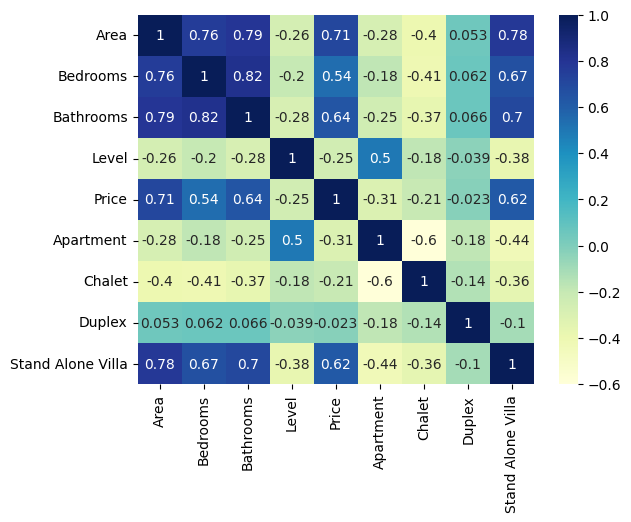

In [54]:
sns.heatmap(train_data.corr(),annot=True,cmap="YlGnBu")